In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point, Polygon
from scipy.spatial import KDTree
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [22]:

def idw_interpolation(gdf, grid_gdf, radius=0, exponent=2, vname=''):
    # Crear un nuevo GeoDataFrame solo con la geometría de la grilla
    interpolated_gdf = gpd.GeoDataFrame({'geometry': grid_gdf['geometry']})
    if radius==0:
        # Iterar sobre los puntos de la grilla
        for idx, point in interpolated_gdf.iterrows():
            distances = gdf.distance(point.geometry)
            weights = 1 / (distances + 0.000001) ** exponent  # Se agrega un pequeño valor para evitar divisiones por cero
            interpolated_value = np.sum(weights * gdf[vname]) / np.sum(weights)
            interpolated_gdf.loc[idx, 'pred'] = interpolated_value
    else:
        # Iterar sobre los puntos de la grilla
        for idx, point in interpolated_gdf.iterrows():
            distances = gdf.distance(point.geometry)
            if len(distances[distances <= radius])!=0:
                # Aplicar distancia máxima (radius)
                distances = distances[distances <= radius]
            else:
                distances = distances[distances <= radius*2]
            if len(distances)==0:print("No hay puntos")
            weights = 1 / (distances + 0.000001) ** exponent  # Se agrega un pequeño valor para evitar divisiones por cero
            interpolated_value = np.sum(weights * gdf[vname].loc[distances.index]) / np.sum(weights)
            interpolated_gdf.loc[idx, 'pred'] = interpolated_value
    return interpolated_gdf


def average_nearest_neighbor_distance(gdf):
    """
    Calcula la distancia promedio al vecino más cercano para un GeoDataFrame de puntos.

    Args:
        gdf (geopandas.GeoDataFrame): GeoDataFrame que contiene geometrías de puntos.

    Returns:
        float: Distancia promedio al vecino más cercano.
    """
    # Extraer las coordenadas de los puntos en el GeoDataFrame
    points = gdf.geometry.apply(lambda point: (point.x, point.y)).tolist()

    # Construir el árbol KD
    tree = KDTree(points)

    # Calcular la distancia al vecino más cercano para cada punto
    distances, _ = tree.query(points, k=2)  # k=2 para encontrar el vecino más cercano (el punto en sí mismo es el más cercano)

    # La distancia al vecino más cercano de cada punto es la segunda columna de la matriz distances
    nearest_distances = distances[:, 1]

    # Calcular la distancia promedio al vecino más cercano
    average_nearest_distance = nearest_distances.mean()

    return average_nearest_distance


def plot_predictions(predictions,vname = 'pred',
colors = [],breaks = [],
plot_size=[10,10], show_plot=True,plot_title = 'Predictions over the grid',
legend_title='Legend',legend=True):
    if len(colors)==0 and len(breaks)==0:
        colors = ['#8FE60C','#ADFF2F','#FFFF00','#FFD700','#FF4500','#FF2500','#FF0000']
        min, max = int(predictions[vname].min())-1,int(predictions[vname].max())+1
        breaks = np.linspace(min, max, 8, endpoint=True)
        breaks = np.round(breaks).astype(int)
        print(len(breaks))
    elif len(colors)+1!=len(breaks):
        return "You must specify a color for each interval"
    elif len(plot_size)!=2 or not isinstance(plot_size,list):
        return "The size of the graph must be specified in a list of two elements"
    elif not isinstance(predictions,gpd.GeoDataFrame):
        return "The grid with the predictions is expected to be a GeoDataFrame"
    elif not vname in predictions.columns:
        return "The name of the variable to plot is not found in the grid"    
    # Create the custom color scale
    cmap = mcolors.ListedColormap(colors)
    # Define color boundaries
    norm = mcolors.BoundaryNorm(breaks, cmap.N)
    # Create a figure and its axes
    fig, ax = plt.subplots(figsize=(8, 8))
    # Plot the grid with predictions
    predictions.plot(ax=ax, column=vname, cmap=cmap, norm=norm,legend=False)
    # Add plot title
    ax.set_title(plot_title)
    # Removing the x y axis from plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if legend:
        # Create a custom legend
        legend_elements = []
        for i in range(1,len(breaks)):
            legend_elements.append(Line2D([0], [0], marker='s', color='w', label=f'{breaks[i-1]}-{breaks[i]}', markerfacecolor=colors[i-1], markersize=10))
        # Add the legend to plot
        ax.legend(handles=legend_elements, title=legend_title)
    # Show the plot
    if show_plot:
        plt.show()
    # Return the figure and plot
    return fig, ax

def idw_cross_validation(data = None,vname='',
folds = 5,seed = None,
debug=False,plot_res=False,
idps = np.arange(1, 3.25, 0.25),
restringe=False,dist_m=np.array([5,10,100,1000]),
bound_grid = None, grid_res = 10, grid_geom = 'Point'):
    if not isinstance(data,gpd.GeoDataFrame):
        return "Falta el parametro data que espera un objeto del tipo GeoPandas"
    X = data['geometry']
    kf = KFold(n_splits=folds,shuffle=True, random_state=seed)
    kf.get_n_splits(X)
    result = pd.DataFrame({'idp':[],'rmse':[],'dist':[]})
    if restringe:
        dist_nn = average_nearest_neighbor_distance(data)
        best_rmse, best_idp, best_prediction, best_dist = np.inf, None, None, None
        for dist in dist_m:
            for idp in idps:
                if debug:print("idp:",round(idp,2), " - Dist: ", dist," ...")
                for i, (train_index, test_index) in enumerate(kf.split(X)):
                    if i==0:
                        temp_gdf = idw_interpolation(gdf=data.iloc[train_index],grid_gdf=data.iloc[test_index],vname=vname,exponent=idp,radius=dist_nn*dist)
                        temp_gdf['obs']=data.iloc[test_index][vname].values
                    else:  
                        trained_gdf = idw_interpolation(gdf=data.iloc[train_index],grid_gdf=data.iloc[test_index],vname=vname,exponent=idp,radius=dist_nn*dist)
                        trained_gdf['obs']=data.iloc[test_index][vname].values
                        temp_gdf = pd.concat([temp_gdf,trained_gdf])
                # Calculating the RMSE using the observed and predicted values ​​in the DataFrame
                rmse = np.sqrt(mean_squared_error(temp_gdf['obs'], temp_gdf['pred']))
                result = pd.concat([result, pd.DataFrame({'idp':[idp],'rmse':[rmse],'dist':[dist]})])
                if debug:print("RMSE: ",round(rmse,2))
                if best_rmse>rmse:
                    best_rmse, best_idp, best_prediction, best_dist = rmse, idp, temp_gdf, dist
        print("Best idp: ",best_idp," - Best distance: ",best_dist," - Best RMSE: ",best_rmse)
        if plot_res:
            dist_values = result['dist'].unique()
            plt.figure(figsize=(10, 6))
            for dist_value in dist_values:
                subset = result[result['dist'] == dist_value]
                plt.plot(subset['idp'], subset['rmse'], marker='o', linestyle='-', label=f'Dist: {dist_value}')
            plt.xlabel('IDP')
            plt.ylabel('RMSE')
            plt.title('IDP vs RMSE for Different Distances')
            plt.legend()
            plt.grid(True)
            plt.show()
        if isinstance(bound_grid, gpd.GeoDataFrame):
            print("Predicting over the grid...")
            # Creating a grid of points with the resolution specified in grid_res within the polygon area
            minx, miny, maxx, maxy = bound_grid.total_bounds
            x_coords = range(int(minx), int(maxx), grid_res)
            y_coords = range(int(miny), int(maxy), grid_res)       
            # Create an empty list to store the grid points
            grid_points = []
            # Iterate over each coordinate in the grid
            for x in x_coords:
                for y in y_coords:
                    # Create a point with the current coordinates
                    point = Point(x + grid_res/2, y + grid_res/2)  # Use the center point of each cell                
                    # Add the point to the list
                    grid_points.append(point)
            # Create a GeoDataFrame from the list of points
            grid = gpd.GeoDataFrame(geometry=grid_points, crs=bound_grid.crs)
            # Intersect the grid with the polygon to eliminate cells that are outside the perimeter
            intersect_grid = gpd.overlay(grid, bound_grid, how='intersection')
            # Apply the IDW model to predict the values ​​on the grid
            intersect_grid = idw_interpolation(gdf=data,grid_gdf=intersect_grid,vname=vname,exponent=best_idp,radius=dist_nn*best_dist)
            # If required, transform the Point grid to a Polygon grid
            if grid_geom=='Polygon':
                grid_poly=[]
                for punto in intersect_grid['geometry']:
                    x, y = punto.x, punto.y
                    grid_poly.append(Polygon([(x-grid_res/2, y-grid_res/2), (x+grid_res/2, y-grid_res/2), (x+grid_res/2, y+grid_res/2), (x-grid_res/2, y+grid_res/2)]))
                intersect_grid = gpd.GeoDataFrame({'geometry': grid_poly, 'pred': intersect_grid['pred']})
        else:
            intersect_grid = gpd.GeoDataFrame(columns=['geometry','pred'], geometry='geometry')
        return best_prediction, result, intersect_grid, best_idp, best_rmse, best_dist
    else:
        best_rmse, best_idp, best_prediction, best_dist = np.inf, None, None, None       
        for idp in idps:
            if debug:print("idp:",round(idp,2)," ...")
            for i, (train_index, test_index) in enumerate(kf.split(X)):
                if i==0:
                    temp_gdf = idw_interpolation(gdf=data.iloc[train_index],grid_gdf=data.iloc[test_index],vname=vname,exponent=idp)
                    temp_gdf['obs']=data.iloc[test_index][vname].values
                else:  
                    trained_gdf = idw_interpolation(gdf=data.iloc[train_index],grid_gdf=data.iloc[test_index],vname=vname,exponent=idp)
                    trained_gdf['obs']=data.iloc[test_index][vname].values
                    temp_gdf = pd.concat([temp_gdf,trained_gdf])
            # Calculating the RMSE using the observed and predicted values ​​in the DataFrame
            rmse = np.sqrt(mean_squared_error(temp_gdf['obs'], temp_gdf['pred']))
            result = pd.concat([result, pd.DataFrame({'idp':[idp],'rmse':[rmse],'dist':[None]})])
            if debug:print("RMSE: ",round(rmse,2))
            if best_rmse>rmse:
                best_rmse, best_idp, best_prediction = rmse, idp, temp_gdf
        print("Best idp: ",best_idp," - Best RMSE: ",best_rmse)
        if plot_res:
            plt.figure(figsize=(10, 6))
            plt.plot(result['idp'], result['rmse'], marker='o', linestyle='-')
            plt.xlabel('IDP')
            plt.ylabel('RMSE')
            plt.title('IDP vs RMSE')
            plt.legend()
            plt.grid(True)
            plt.show()
        if isinstance(bound_grid, gpd.GeoDataFrame):
            print("Predicting over the grid...")
            # Creating a grid of points with the resolution specified in grid_res within the polygon area
            minx, miny, maxx, maxy = bound_grid.total_bounds
            x_coords = range(int(minx), int(maxx), grid_res)
            y_coords = range(int(miny), int(maxy), grid_res)       
            # Create an empty list to store the grid points
            grid_points = []
            # Iterate over each coordinate in the grid
            for x in x_coords:
                for y in y_coords:
                    # Create a point with the current coordinates
                    point = Point(x + grid_res/2, y + grid_res/2)  # Use the center point of each cell                
                    # Add the point to the list
                    grid_points.append(point)
            # Create a GeoDataFrame from the list of points
            grid = gpd.GeoDataFrame(geometry=grid_points, crs=bound_grid.crs)
            # Intersect the grid with the polygon to eliminate cells that are outside the perimeter
            intersect_grid = gpd.overlay(grid, bound_grid, how='intersection')
            # Apply the IDW model to predict the values ​​on the grid
            intersect_grid = idw_interpolation(gdf=data,grid_gdf=intersect_grid,vname=vname,exponent=best_idp)
            # If required, transform the Point grid to a Polygon grid
            if grid_geom=='Polygon':
                grid_poly=[]
                for punto in intersect_grid['geometry']:
                    x, y = punto.x, punto.y
                    grid_poly.append(Polygon([(x-grid_res/2, y-grid_res/2), (x+grid_res/2, y-grid_res/2), (x+grid_res/2, y+grid_res/2), (x-grid_res/2, y+grid_res/2)]))
                intersect_grid = gpd.GeoDataFrame({'geometry': grid_poly, 'pred': intersect_grid['pred']})
        else:
            intersect_grid = gpd.GeoDataFrame(columns=['geometry','pred'], geometry='geometry')
        return best_prediction, result, intersect_grid, best_idp, best_rmse, best_dist

In [ ]:
# Cargar tus datos en un GeoDataFrame
data = gpd.read_file(filename="Data/ECa.gpkg",layer="EC_field_04")
pred, list_idp, idp, rmse, dist = idw_cross_validation(data=data,vname='EC30',seed=701408733)

In [ ]:
# Cargar tus datos en un GeoDataFrame
data = gpd.read_file(filename="Data/ECa.gpkg",layer="EC_field_02")
pred, list_idp, idp, rmse, dist = idw_cross_validation(data=data,vname='EC30',seed=701408733,restringe=True,dist_m=np.array([5,10,100]))

In [ ]:
# Cargar tus datos en un GeoDataFrame
data = gpd.read_file(filename="Data/ECa.gpkg",layer="EC_field_02")
pred, list_idp, idp, rmse, dist = idw_cross_validation(data=data,vname='EC30',seed=701408733,idps=np.arange(1,2.75,0.25),
restringe=True,dist_m=np.array([5,10,100]),plot_res=True,debug=True)

In [8]:
# Cargar tus datos en un GeoDataFrame
data = gpd.read_file(filename="Data/ECa.gpkg",layer="EC_field_04")
bound = gpd.read_file(filename="Data/F05_boundary.gpkg")
# pred, result, grid, idp, rmse, dist = idw_cross_validation(data=data,vname='EC30',plot_res=True,bound_grid=bound,grid_geom='Polygon',seed=701408733,restringe=True,dist_m=np.array([5,10]),idps=np.arange(2.5,4.25,0.25))
pred, result, grid = idw_cross_validation(data=data,vname='EC30',bound_grid=bound,grid_geom='Polygon',seed=701408733,restringe=True,dist_m=np.array([5]),idps=np.array([3]))[:3]

Best idp:  3  - Best distance:  5  - Best RMSE:  2.295533522970033
Predicting over the grid...


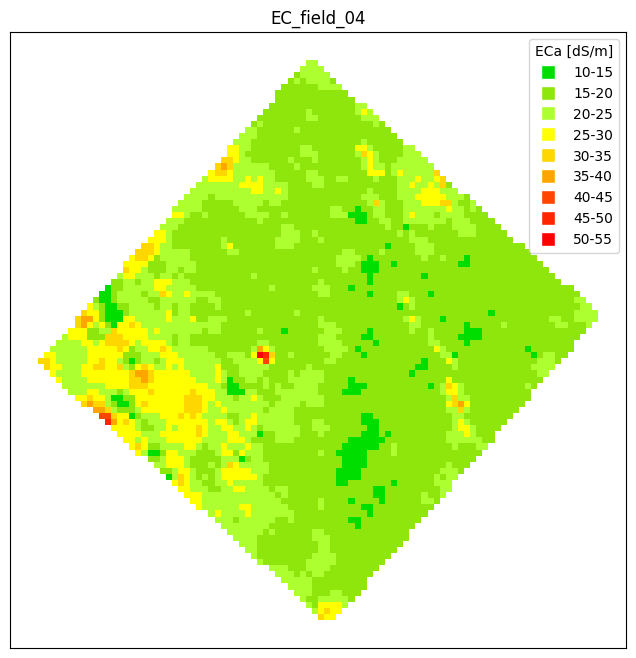

(<Figure size 800x800 with 1 Axes>, <Axes: title={'center': 'EC_field_04'}>)

In [24]:
colors = [
    '#00DE00',
    '#8FE60C',
    '#ADFF2F',
    '#FFFF00',
    '#FFD700',
    '#FFA500',
    '#FF4500',
    '#FF2500',
    '#FF0000'
]
breaks = [10, 15, 20, 25, 30, 35, 40, 45, 50 , 55]
#breaks = [10, 20, 30, 40, 50, 60]
plot_predictions(predictions=grid,colors=colors,breaks=breaks,plot_title='EC_field_04',legend_title='ECa [dS/m]')

8


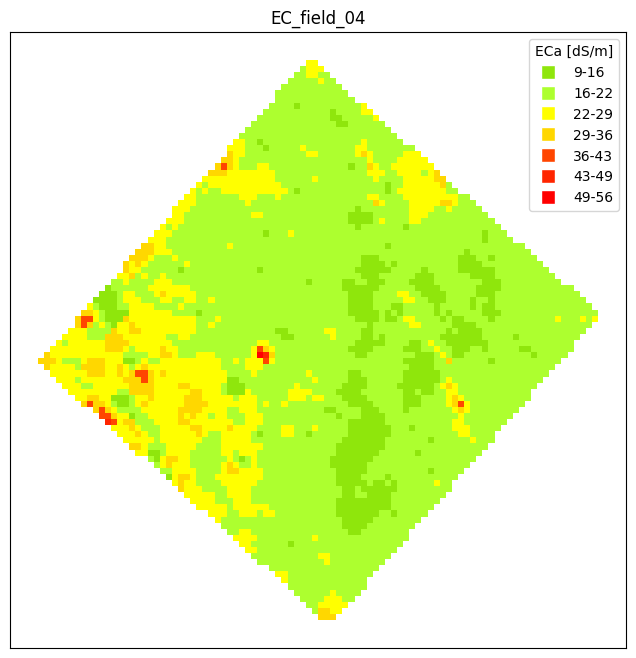

(<Figure size 800x800 with 1 Axes>, <Axes: title={'center': 'EC_field_04'}>)

In [23]:
plot_predictions(predictions=grid,plot_title='EC_field_04',legend_title='ECa [dS/m]')

In [2]:
sunflower = gpd.read_file(filename="Data/F05_sunflower_0708.gpkg")
